In [64]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import glob
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb


<h1>Testing of the models starts here </h1>

In [61]:
testing_img = 'testing/karachi_16_march.jp2'

Breaking the image into (100x100)px smaller images 

In [57]:
import os
from PIL import Image

def split_image_to_fixed_size(image_path, tile_size, output_folder):
    """
    Splits an image into smaller images of a fixed size and saves them to a specified folder.

    Args:
        image_path (str): Path to the input image.
        tile_size (tuple): Size of each tile (width, height).
        output_folder (str): Folder to save the smaller images.

    Returns:
        None
    """
    # Open the input image
    image = Image.open(image_path)
    image_width, image_height = image.size

    # Calculate the size of each tile
    tile_width, tile_height = tile_size

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Split the image into smaller images and save them
    for top in range(0, image_height, tile_height):
        for left in range(0, image_width, tile_width):
            right = min(left + tile_width, image_width)
            bottom = min(top + tile_height, image_height)

            # Crop the image
            cropped_image = image.crop((left, top, right, bottom))

            # Save the cropped image
            cropped_image.save(os.path.join(output_folder, f'image_{top}_{left}.png'))


In [59]:
split_image_to_fixed_size(testing_img, (100, 100), 'testing/input_images')

<h3>Displaying example input images</h3>

Input Images


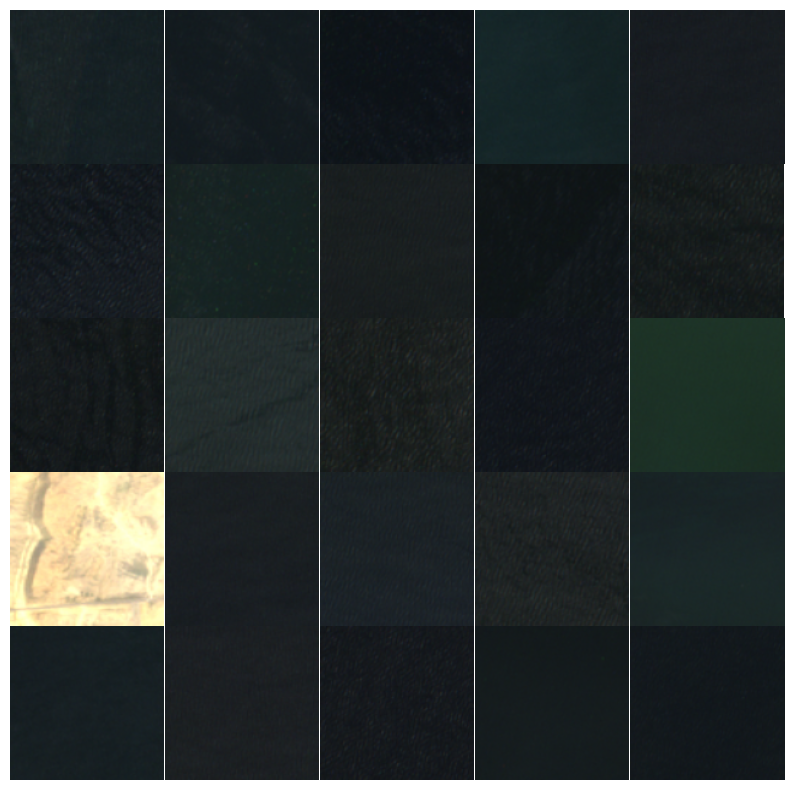

In [67]:
print("Input Images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('testing/input_images/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


<h3>Check for objects and remove unnecessary</h3>

In [68]:
def process_and_filter_images(input_folder):
    """
    Processes images in the input folder to detect objects and deletes images with no objects.

    Args:
        input_folder (str): Path to the folder containing images.

    Returns:
        None
    """
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Read image and preprocess
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_name}. Skipping.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (9, 9), 0)

        edged = cv2.Canny(blur, 50, 100)
        edged = cv2.dilate(edged, None, iterations=1)
        edged = cv2.erode(edged, None, iterations=1)

        # Find contours
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if cnts:
            # Draw rectangles around objects
            for cnt in cnts:
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Convert image from BGR to RGB for displaying with Matplotlib
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            # If no contours are found, delete the image
            os.remove(image_path)
            print(f"No objects found in {image_name}. Image deleted")

process_and_filter_images('testing/input_images')


No objects found in image_2700_4600.png. Image deleted
No objects found in image_6900_8100.png. Image deleted
No objects found in image_9800_3500.png. Image deleted
No objects found in image_900_3800.png. Image deleted
No objects found in image_2900_400.png. Image deleted
No objects found in image_10800_3600.png. Image deleted
No objects found in image_10600_10600.png. Image deleted
No objects found in image_5300_2200.png. Image deleted
No objects found in image_8100_4900.png. Image deleted
No objects found in image_9800_7000.png. Image deleted
No objects found in image_10800_900.png. Image deleted
No objects found in image_5300_6700.png. Image deleted
No objects found in image_10800_7300.png. Image deleted
No objects found in image_8500_4000.png. Image deleted
No objects found in image_7200_10500.png. Image deleted
No objects found in image_2000_2000.png. Image deleted
No objects found in image_5400_4400.png. Image deleted
No objects found in image_8200_6300.png. Image deleted
No obje

<h3>Move all land images to another folder (or) delete if not needed.</h3>

In [69]:
def predictions(model, img_path,IMG_SIZE):
    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    return i

In [70]:
land_model=load_model('land_model.h5')

In [71]:
import os
import shutil

def filter_and_move_files(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through files in input folder
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        preds = predictions(land_model,file_path,100)
        # Check if the file meets the condition
        if preds==0:
            # Move the file to the output folder
            shutil.move(file_path, os.path.join(output_folder, filename))
            print(f"File {file_path} has been moved to the folder")


In [72]:
input_folder = 'testing/input_images'
output_folder = 'testing/land_images'

# Filter and move files based on the condition
filter_and_move_files(input_folder, output_folder)

1/1 [==============================] - 0s 155ms/step
File testing/input_images/image_1900_10900.png has been moved to the folder
1/1 [==============================] - 0s 19ms/step
File testing/input_images/image_4400_9200.png has been moved to the folder
1/1 [==============================] - 0s 16ms/step
File testing/input_images/image_400_10100.png has been moved to the folder
1/1 [==============================] - 0s 17ms/step
File testing/input_images/image_3700_9000.png has been moved to the folder
1/1 [==============================] - 0s 16ms/step
File testing/input_images/image_3300_9900.png has been moved to the folder
1/1 [==============================] - 0s 17ms/step
File testing/input_images/image_600_10900.png has been moved to the folder
1/1 [==============================] - 0s 17ms/step
File testing/input_images/image_1300_9100.png has been moved to the folder
1/1 [==============================] - 0s 17ms/step
File testing/input_images/image_2900_7700.png has been mo

Land images


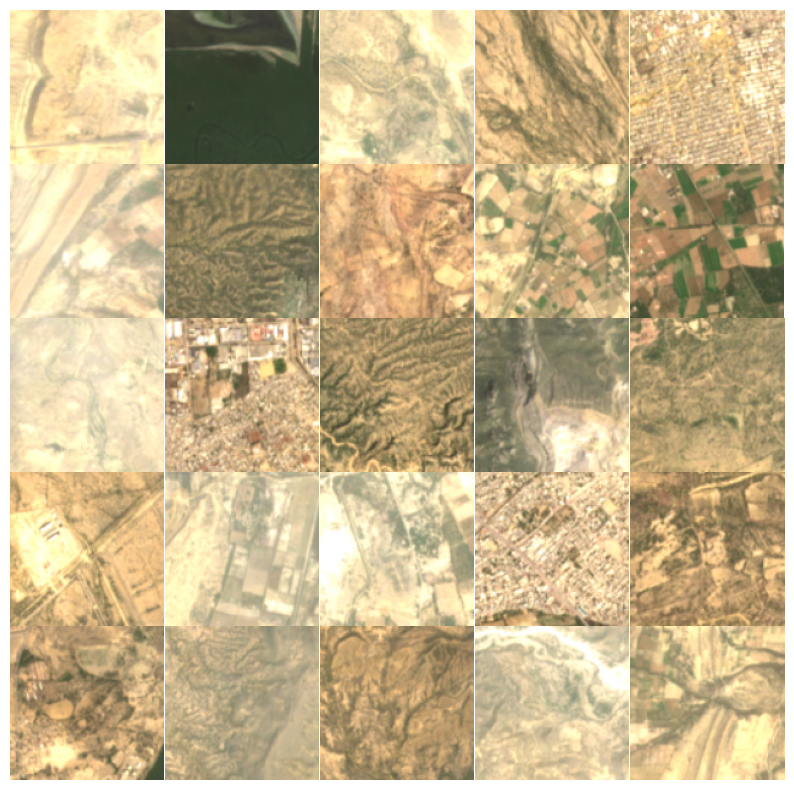

In [73]:
print("Land images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('testing/land_images/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


<h3>Moving all ship images to another folder</h3>

In [74]:
model = load_model('ship-model.h5')

In [75]:
import os
import shutil

def filter_and_move_files(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through files in input folder
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        preds = predictions(model,file_path,48)
        # Check if the file meets the condition
        if preds==1:
            # Move the file to the output folder
            shutil.move(file_path, os.path.join(output_folder, filename))
            print(f"File {file_path} has been moved to the folder")


In [76]:
input_folder = 'testing/input_images'
output_folder = 'testing/ship_images'

# Filter and move files based on the condition
filter_and_move_files(input_folder, output_folder)

1/1 [==============================] - 0s 14ms/step
File testing/input_images/image_4500_6400.png has been moved to the folder
1/1 [==============================] - 0s 12ms/step
File testing/input_images/image_5500_10100.png has been moved to the folder
1/1 [==============================] - 0s 13ms/step
File testing/input_images/image_2600_7200.png has been moved to the folder
1/1 [==============================] - 0s 13ms/step
File testing/input_images/image_1900_3600.png has been moved to the folder
1/1 [==============================] - 0s 12ms/step
File testing/input_images/image_6100_8400.png has been moved to the folder
1/1 [==============================] - 0s 12ms/step
File testing/input_images/image_7800_10100.png has been moved to the folder
1/1 [==============================] - 0s 15ms/step
File testing/input_images/image_8000_10500.png has been moved to the folder
1/1 [==============================] - 0s 15ms/step
File testing/input_images/image_7800_10500.png has been 

It is observed that the false positive rate for ship classification is quite high due to the presence of clouds. To counter this, another model for removing the images that have clouds can be trained, and shall be done subsequently. 

Ship images


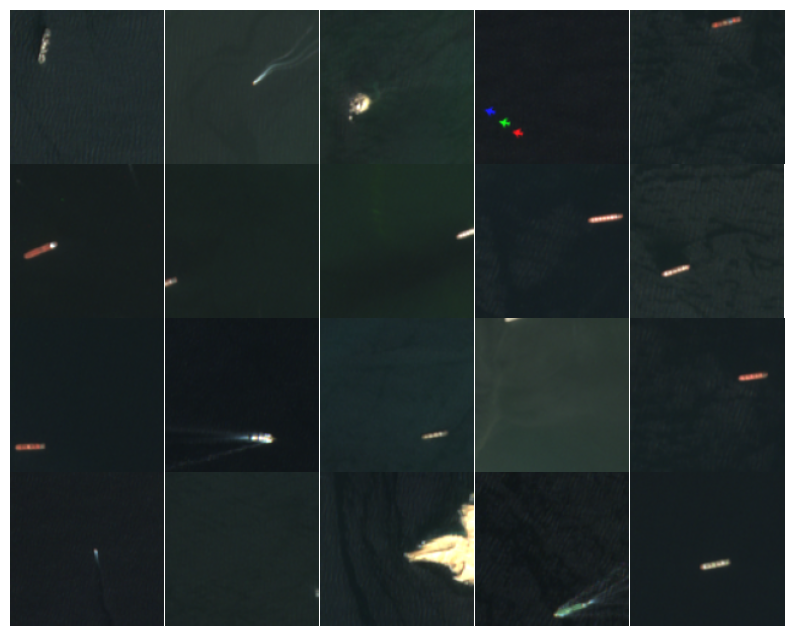

In [77]:
print("Ship images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('testing/ship_images/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


<h3>Move all false positives based on size to another folder.</h3>

In [78]:
import cv2
import os
import imutils
import shutil

def move_small_objects_images(input_folder, output_folder, min_length_px=10):
    """
    Processes images in the input folder, and moves images with objects less than a specified length to another folder.

    Args:
        input_folder (str): Path to the folder containing images.
        output_folder (str): Path to the folder where images with small objects will be moved.
        min_length_px (int): Minimum length of objects in pixels to be considered significant.

    Returns:
        None
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Read image and preprocess
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image {image_name}. Skipping.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (9, 9), 0)

        edged = cv2.Canny(blur, 50, 100)
        edged = cv2.dilate(edged, None, iterations=1)
        edged = cv2.erode(edged, None, iterations=1)

        # Find contours
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if not cnts:
            print(f"No objects found in {image_name}. Skipping.")
            continue

        move_image = False
        for cnt in cnts:
            x, y, w, h = cv2.boundingRect(cnt)
            length_px = max(w, h)
            if length_px < min_length_px:
                move_image = True
                break

        if move_image:
            shutil.move(image_path, os.path.join(output_folder, image_name))
            print(f"Moved {image_name} to {output_folder}.")

# Example usage
input_folder = 'testing/ship_images'
output_folder = 'testing/small_objects_images'
move_small_objects_images(input_folder, output_folder)


Moved image_2600_7200.png to testing/small_objects_images.
Moved image_1900_3600.png to testing/small_objects_images.
Moved image_8000_10500.png to testing/small_objects_images.
Moved image_4000_900.png to testing/small_objects_images.
Moved image_2500_7000.png to testing/small_objects_images.
Moved image_4100_6300.png to testing/small_objects_images.


Ship images after removing false positives


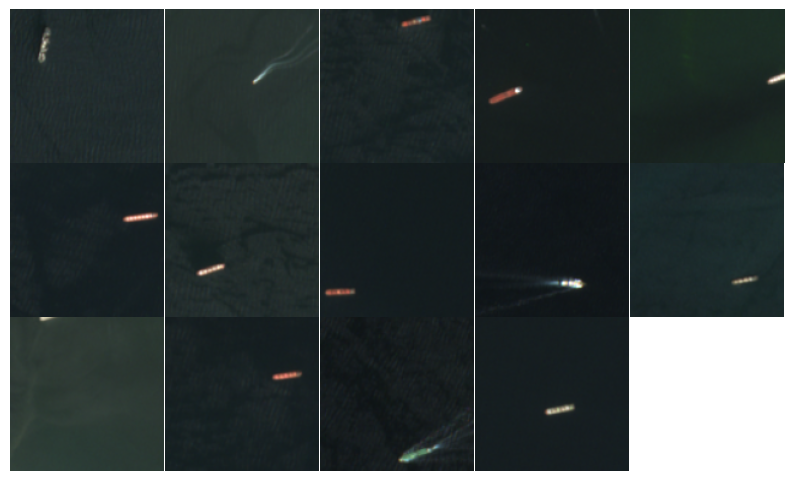

In [79]:
print("Ship images after removing false positives")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('testing/ship_images/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)
    
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


<h3>Measuring the sizes of all ships</h3>

In [94]:
import cv2
import imutils
import matplotlib.pyplot as plt

def detect_and_display_objects(image_path):
    """
    Processes an image to detect objects and display lengths in pixels.

    Args:
        image_path (str): Path to the image file.

    Returns:
        None
    """
    # Read image and preprocess
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_path}. Exiting.")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)

    edged = cv2.Canny(blur, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        print("No objects found. Exiting.")
        return

    # Draw rectangles around objects and display lengths in pixels
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Calculate length in pixels
        length_px = max(w, h)

        # Display length as text
        cv2.putText(image, "{:.2f} px".format(length_px), (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Convert image from BGR to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    # Plot the image using Matplotlib
    plt.imshow(image_rgb)
    plt.title("Detected Objects with Lengths (px)")
    plt.axis('off')
    plt.show()


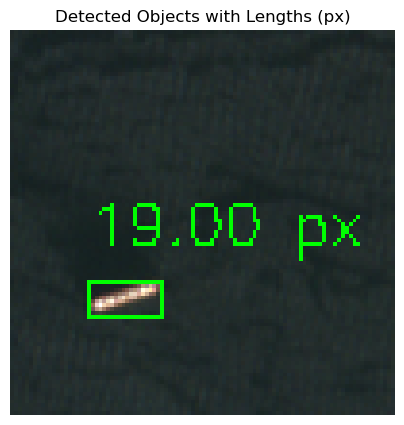

In [95]:
image_path = 'testing/ship_images/image_5500_8200.png'
detect_and_display_objects(image_path)

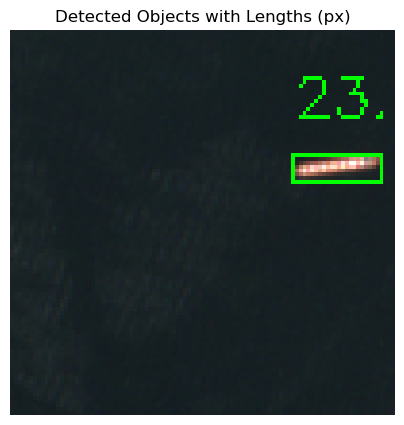

In [96]:
image_path = 'testing/ship_images/image_6400_8400.png'
detect_and_display_objects(image_path)

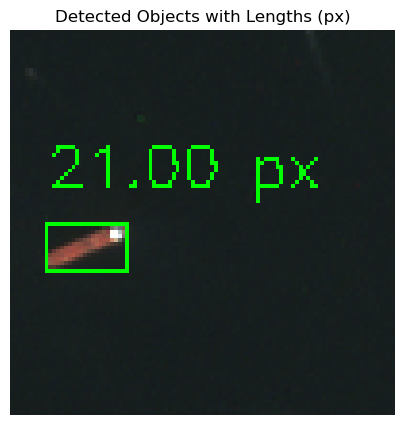

In [97]:
image_path = 'testing/ship_images/image_7800_10100.png'
detect_and_display_objects(image_path)

In [85]:
import cv2
import imutils
import os

def detect_objects(image):
    """
    Detects objects in an image and returns their sizes in pixels.

    Args:
        image (numpy.ndarray): Image array.

    Returns:
        list: List of sizes (lengths) of detected objects in pixels.
    """
    # Preprocess the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    edged = cv2.Canny(blur, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # List to store sizes of detected objects
    object_sizes = []

    # Measure sizes of objects
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        length_px = max(w, h)
        object_sizes.append(length_px)
    print(object_sizes,end=" ")
    return object_sizes

def classify_size(size):
    """
    Classifies the size into different classes.

    Args:
        size (int): Size of the object in pixels.

    Returns:
        str: Class name.
    """
    if 10 <= size <= 15:
        return "Class A"
    elif 16 <= size <= 20:
        return "Class B"
    elif 21 <= size <= 25:
        return "Class C"
    elif 26 <= size <= 30:
        return "Class D"
    else:
        return None

def measure_objects_in_directory(directory_path):
    """
    Measures the sizes of objects in all images within a directory.

    Args:
        directory_path (str): Path to the directory containing images.

    Returns:
        dict: Dictionary with counts of objects in each class.
    """
    # Dictionary to store counts of each class
    class_counts = {"Class A": 0, "Class B": 0, "Class C": 0, "Class D": 0}

    # Iterate over all images in the directory
    for filename in os.listdir(directory_path):
        # Read the image
        image_path = os.path.join(directory_path, filename)
        image = cv2.imread(image_path)

        # Skip if it's not a valid image
        if image is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Detect objects in the image and get their sizes
        object_sizes = detect_objects(image)
        
        # Classify each size and update counts
        for size in object_sizes:
            class_name = classify_size(size)
            if class_name:
                class_counts[class_name] += 1

    return class_counts

def main(directory_path):
    """
    Main function to measure sizes of objects in images within a directory.

    Args:
        directory_path (str): Path to the directory containing images.

    Returns:
        None
    """
    # Measure sizes of objects in all images in the directory
    class_counts = measure_objects_in_directory(directory_path)

    # Print the counts of each class
    print("\nCounts of objects in each class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    

# Example usage:
directory_path = 'testing/ship_images/'
main(directory_path)


[23] [16] [20] [21] [11] [23] [19] [20] [26] [17] [10] [20] [30] [19] 
Counts of objects in each class:
Class A: 2
Class B: 7
Class C: 3
Class D: 2
